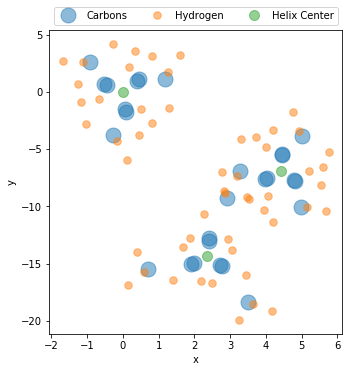

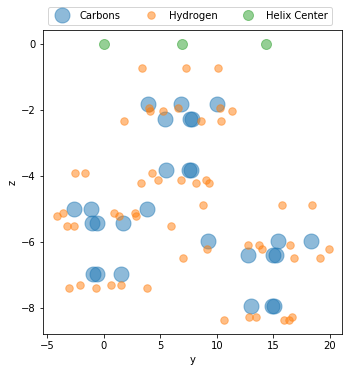

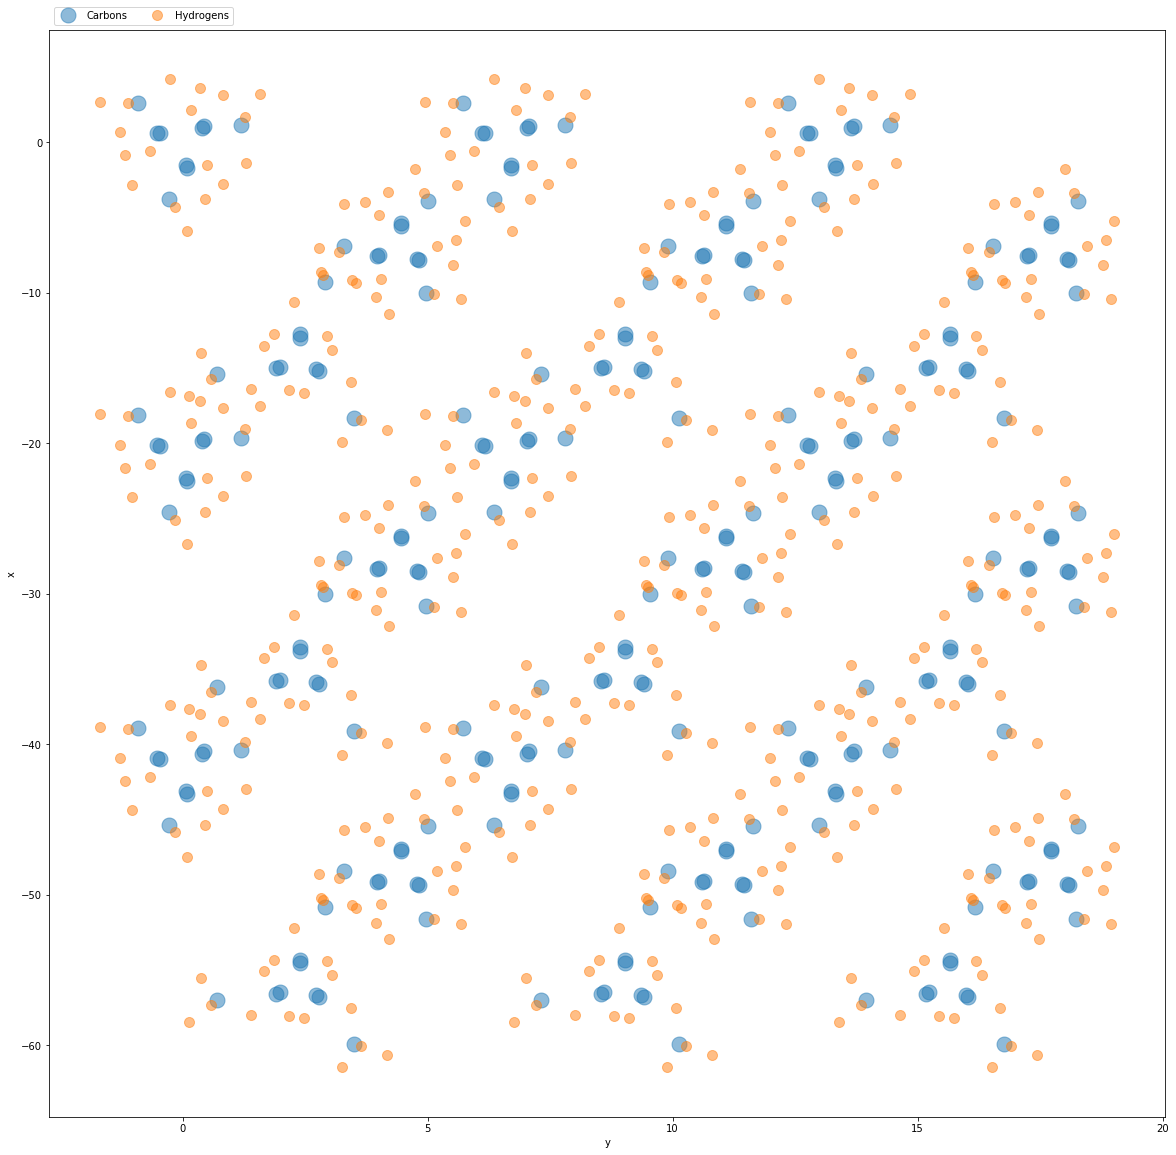

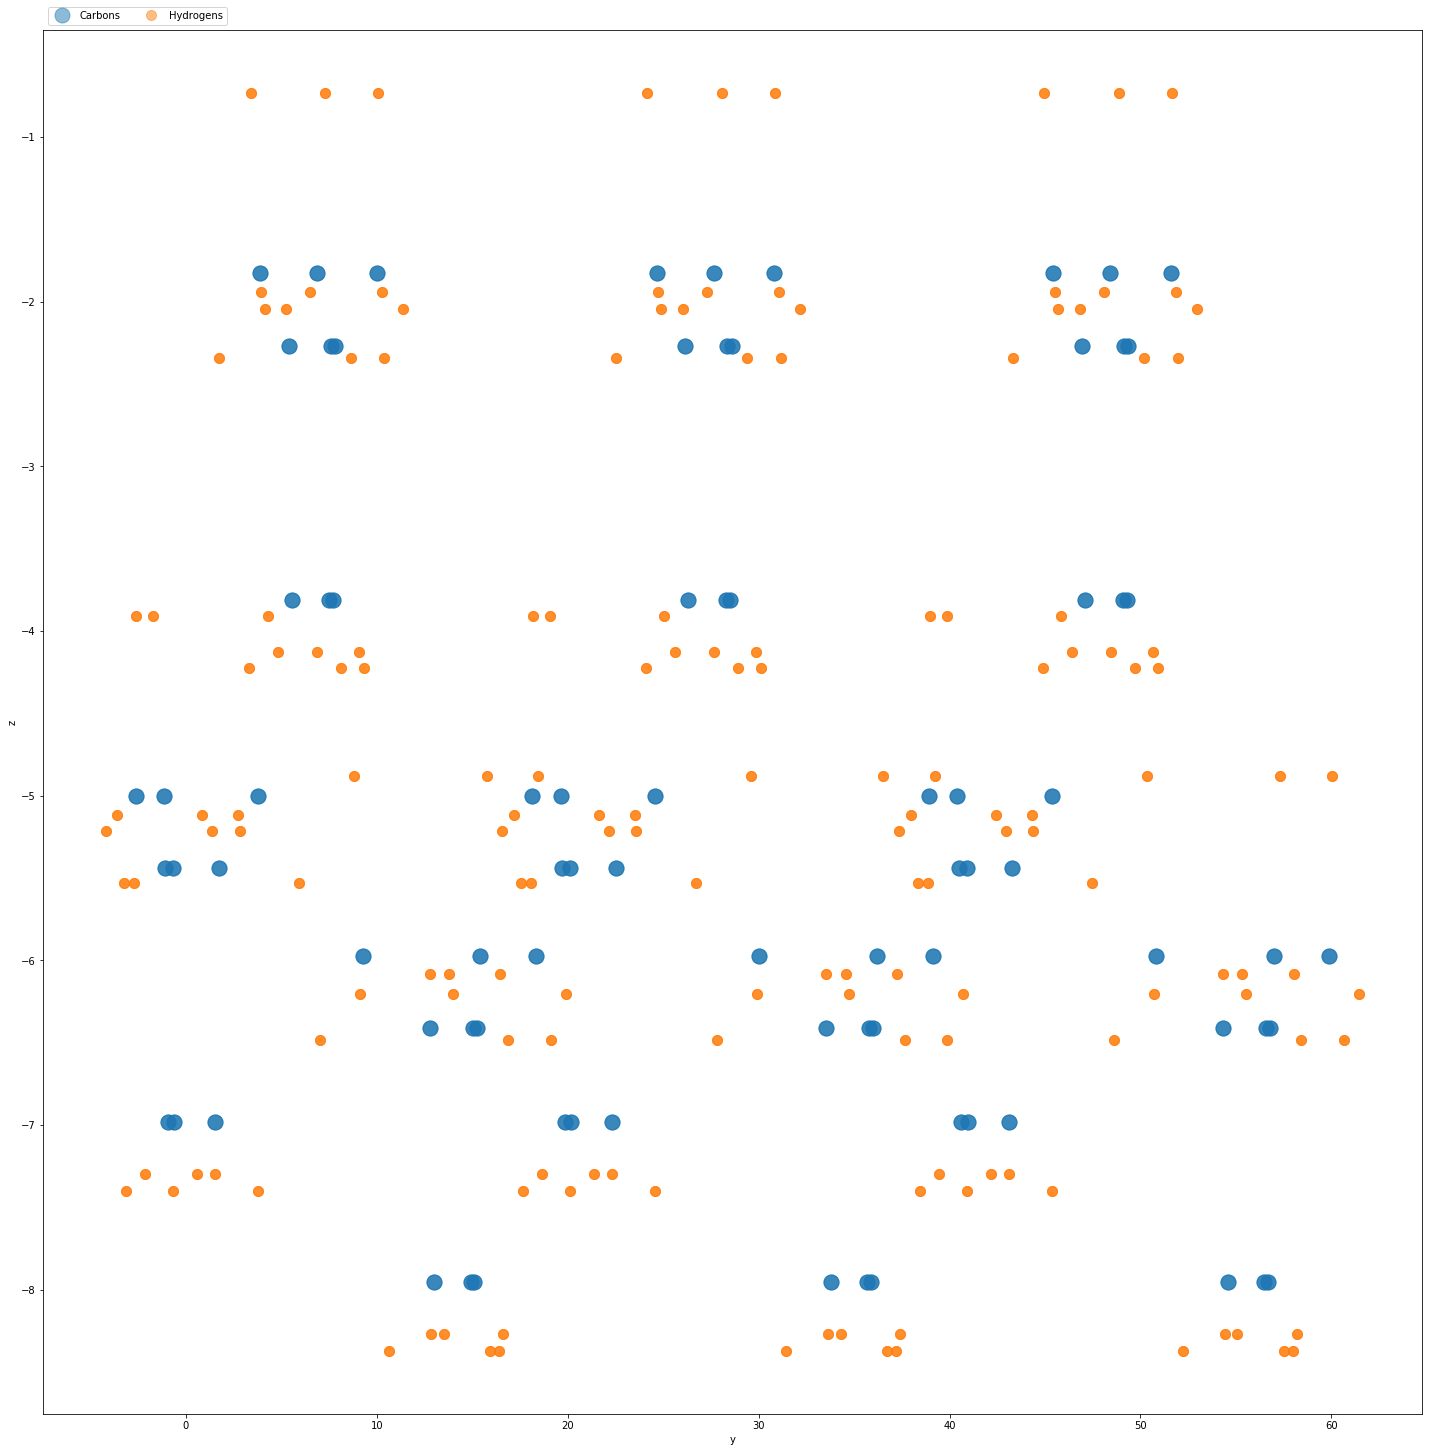

In [36]:
import numpy
import math
from matplotlib import pyplot

''' Atomistic fractional coordinates for the P31_21 Model
(from D.R Ferro et. al. 1998)'''


''' 
Chain_A = numpy.array([[0.0096, 0.0737, -1.0744],
                       [0.0679, 0.1819, -1.1389],
                       [-0.1017, 0.0291, -1.1226],
                       [0.0122, 0.0831, -0.8373],
                       [0.1238, 0.1323, -0.7878],
                       [-0.0411, 0.1822, -0.7694],
                       [-0.1550, 0.1355, -0.8021],
                       [-0.0246, 0.2065, -0.6019]])

Chain_B = numpy.array([[0.4101, 0.7264, -1.2238],
                       [0.5174, 0.7673, -1.2880],
                       [0.3747, 0.8007, -1.2723],
                       [0.4190, 0.7327, -0.9865],
                       [0.4595, 0.6628, -0.9362],
                       [0.5276, 0.8825, -0.9189],
                       [0.6300, 0.9196, -0.9979],
                       [0.4910, 0.9579, -0.9548],
                       [0.5499, 0.8887, -0.7509]])


Chain_C = numpy.array([[0.6731, 0.2668, -0.5865],               
                       [0.6334, 0.1595, -0.6505],
                       [0.7846, 0.3306, -0.6351],
                       [0.6727, 0.2591, -0.3492],
                       [0.5621, 0.1906, -0.2989],
                       [0.7548, 0.1866, -0.2807],
                       [0.7158, 0.0841, -0.3600],
                       [0.8685, 0.2531, -0.3151],
                       [0.7435, 0.1635, -0.1127]])
                               

def plot_unit_cell1(Chain_A, Chain_B, Chain_C):
    CC = numpy.vstack([numpy.dot(Chain_A, unit_cell), numpy.dot(Chain_B, unit_cell), numpy.dot(Chain_B, unit_cell)])    
    fig1 = pyplot.figure(figsize = (10,5))      
    aC1 = pyplot.plot(CC[:,0], CC[:,1],'.', ms=30, alpha=0.5, label='Carbons')
    pyplot.legend(ncol=4, bbox_to_anchor=(0,1), loc='lower left')
    pyplot.tight_layout()

plot_unit_cell1(Chain_A, Chain_B, Chain_C)
'''

Carbon_chain_A = numpy.array([[0.0096, 0.0737, -1.0744],
                              [0.0122, 0.0831, -0.8373],
                              [-0.0411, 0.1822, -0.7694]])
Hydrogen_chain_A = numpy.array([[0.0679, 0.1819, -1.1389],
                                [-0.1017, 0.0291, -1.1226],
                                [0.1238, 0.1323, -0.7878],
                                [0.0151, 0.2850, -0.8506],
                                [-0.1550, 0.1355, -0.8021],
                                [-0.0246, 0.2065, -0.6019]])    

Carbon_chain_B = numpy.array([[0.4101, 0.7264, -1.2238],
                              [0.4190, 0.7327, -0.9865],
                              [0.5276, 0.8825, -0.9189]])
Hydrogen_chain_B = numpy.array([[0.5174, 0.7673, -1.2880],
                                [0.3747, 0.8007, -1.2723],
                                [0.4595, 0.6628, -0.9362],
                                [0.6300, 0.9196, -0.9979],
                                [0.4910, 0.9579, -0.9548],
                                [0.5499, 0.8887, -0.7509]])

Carbon_chain_C = numpy.array([[0.6731, 0.2668, -0.5865],
                              [0.6727, 0.2591, -0.3492],
                              [0.7548, 0.1866, -0.2807]])
Hydrogen_chain_C = numpy.array([[0.6334, 0.1595, -0.6505],
                                [0.7846, 0.3306, -0.6351],
                                [0.5621, 0.1906, -0.2989],
                                [0.7158, 0.0841, -0.3600],
                                [0.8685, 0.2531, -0.3151],
                                [0.7435, 0.1635, -0.1127]])

''' Helix center of the chains'''
Helix_center = numpy.array([[0.0, 0.0, 0.0],
                           [1.07/3.0, 2.07/3.0, 0.0],
                           [2.0/3.0, 1.0/3.0, 0.0]])

''' Angle between c vector and x-axis. '''
beta = 90.0 * numpy.pi / 180.0

''' Columns of unit_cell are the a, b, and c cell vectors. '''
unit_cell = numpy.array([[6.63,  0.00, 6.50*numpy.cos(beta)],
                         [0.00, 20.78, 0.0],
                         [0.00,  0.00, 6.50*numpy.sin(beta)]])

''' rotation angle'''
theta = 120.0 * numpy.pi/180.0


def rotation_matrix(theta):
    return numpy.array([[numpy.cos(theta), -numpy.sin(theta), 0],
                        [numpy.sin(theta),  numpy.cos(theta), 0],
                        [0.0             ,0.0             , 1.0]])    

def Unit_cell(CCA,CCB,CCC,HCA,HCB,HCC):
    Carbons = numpy.zeros([27,3])
    Hydrogens = numpy.zeros([54,3])    
    
    def __carbons__(CC,i):
        C = numpy.zeros([9,3])
        C[0:3,:] = CC
        C[0:3,:] = C[0:3] - Helix_center[i,:]
        C[3:6,:] = numpy.dot(C[0:3], rotation_matrix(theta))
        C[6:9,:] = numpy.dot(C[3:6,:], rotation_matrix(theta))
        C[0:3,:] = C[0:3] + Helix_center[i,:]
        C[3:6,:] = C[3:6] + Helix_center[i,:]
        C[6:9,:] = C[6:9] + Helix_center[i,:]
        
        return C
        
    def __hydrogens__(HH,i):
        H = numpy.zeros([18,3])
        H[0:6,:] = HH
        H[0:6,:] = H[0:6] - Helix_center[i,:]
        H[6:12,:] = numpy.dot(H[0:6], rotation_matrix(theta))
        H[12:18,:] = numpy.dot(H[6:12,:], rotation_matrix(theta))
        H[0:6,:] = H[0:6] + Helix_center[i,:]
        H[6:12,:] = H[6:12] + Helix_center[i,:]
        H[12:18,:] = H[12:18] + Helix_center[i,:]
        
        return H
    
    Carbons = numpy.vstack([__carbons__(CCA,0),__carbons__(CCB,1),__carbons__(CCC,2)])
    #Carbons = numpy.dot(Carbons, unit_cell)
    
    Hydrogens = numpy.vstack([__hydrogens__(HCA,0),__hydrogens__(HCB,1),__hydrogens__(HCC,2)])
    #Hydrogens = numpy.dot(Hydrogens, unit_cell)
        
    return Carbons, Hydrogens
    
C = numpy.zeros([27,3])
H = numpy.zeros([54,3])
C , H = Unit_cell(Carbon_chain_A,Carbon_chain_B,Carbon_chain_C,Hydrogen_chain_A,Hydrogen_chain_B,Hydrogen_chain_C)
HC = numpy.dot(Helix_center, unit_cell)


def crystal(a, b, c):
    C = numpy.zeros([27,3])
    H = numpy.zeros([54,3])
    C , H = Unit_cell(Carbon_chain_A,Carbon_chain_B,Carbon_chain_C,Hydrogen_chain_A,Hydrogen_chain_B,Hydrogen_chain_C)
    #print(C)
    #print(H)
    Carbons = numpy.zeros([a*b*c*27, 3])
    Hydrogens = numpy.zeros([a*b*c*54, 3])
    
    for i in range(a):
        Carbons[(27*i):(27*(i+1)),0] = C[:,0] + float(i)
        Carbons[(27*i):(27*(i+1)),1] = C[:,1]
        Carbons[(27*i):(27*(i+1)),2] = C[:,2]        
        Hydrogens[(54*i):(54*(i+1)),0] = H[:,0] + float(i)
        Hydrogens[(54*i):(54*(i+1)),1] = H[:,1]
        Hydrogens[(54*i):(54*(i+1)),2] = H[:,2]
        
    for j in range(1,b):
        Carbons[27*(a*j):27*(a*(j+1)),0] = Carbons[0:27*a,0] 
        Carbons[27*(a*j):27*(a*(j+1)),1] = Carbons[0:27*a,1] + float(j)
        Carbons[27*(a*j):27*(a*(j+1)),2] = Carbons[0:27*a,2]        
        Hydrogens[54*(a*j):54*(a*(j+1)),0] = Hydrogens[0:54*a,0] 
        Hydrogens[54*(a*j):54*(a*(j+1)),1] = Hydrogens[0:54*a,1] + float(j)
        Hydrogens[54*(a*j):54*(a*(j+1)),2] = Hydrogens[0:54*a,2]
        
    for k in range(1,c):
        Carbons[27*(a*b*k):27*(a*b*(k+1)),0] = Carbons[0:27*a*b,0] 
        Carbons[27*(a*b*k):27*(a*b*(k+1)),1] = Carbons[0:27*a*b,1]
        Carbons[27*(a*b*k):27*(a*b*(k+1)),2] = Carbons[0:27*a*b,2] + float(k)        
        Hydrogens[54*(a*b*k):54*(a*b*(k+1)),0] = Hydrogens[0:54*a*b,0] 
        Hydrogens[54*(a*b*k):54*(a*b*(k+1)),1] = Hydrogens[0:54*a*b,1] 
        Hydrogens[54*(a*b*k):54*(a*b*(k+1)),2] = Hydrogens[0:54*a*b,2] + float(k)
        
        
    Carbons = numpy.dot(Carbons, unit_cell)
    Hydrogens = numpy.dot(Hydrogens, unit_cell)   
    
    return Carbons, Hydrogens


def plot_unit_cell(CC, HH, HC):
    CC = numpy.dot(CC, unit_cell)
    #print(CC)
    HH = numpy.dot(HH, unit_cell)
    #print(HH)
    fig1 = pyplot.figure(figsize = (5,5))      
    aCC = pyplot.plot(CC[:,0], -CC[:,1],'.', ms=30, alpha=0.5, label='Carbons')
    aHH = pyplot.plot(HH[:,0], -HH[:,1],'.', ms=15, alpha=0.5, label='Hydrogen')
    aCH = pyplot.plot(HC[:,0], -HC[:,1],'.', ms=20, alpha=0.5, label='Helix Center')  
    pyplot.xlabel('x')
    pyplot.ylabel('y')
    pyplot.legend(ncol=4, bbox_to_anchor=(0,1), loc='lower left')
    pyplot.tight_layout()
    
    fig2 = pyplot.figure(figsize = (5,5))      
    aCC = pyplot.plot(CC[:,1], CC[:,2],'.', ms=30, alpha=0.5, label='Carbons')
    aHH = pyplot.plot(HH[:,1], HH[:,2],'.', ms=15, alpha=0.5, label='Hydrogen')
    aCH = pyplot.plot(HC[:,1], HC[:,2],'.', ms=20, alpha=0.5, label='Helix Center')
    pyplot.xlabel('y')
    pyplot.ylabel('z') 
    pyplot.legend(ncol=4, bbox_to_anchor=(0,1), loc='lower left')
    pyplot.tight_layout()
     

plot_unit_cell(C, H, HC)


def plot_crystal(C, H):
    
    fig1 = pyplot.figure(figsize = (20,20))      
    aC1 = pyplot.plot(C[:,0], -C[:,1],'.', ms=30, alpha=0.5, label='Carbons')
    aH1 = pyplot.plot(H[:,0], -H[:,1],'.', ms=20, alpha=0.5, label='Hydrogens')
    pyplot.xlabel('y')
    pyplot.ylabel('x')   
    pyplot.legend(ncol=4, bbox_to_anchor=(0,1), loc='lower left')
    
    fig2 = pyplot.figure(figsize = (20,20))    
    aC2 = pyplot.plot(C[:,1], C[:,2],'.', ms=30, alpha=0.5, label='Carbons')
    aH2 = pyplot.plot(H[:,1], H[:,2],'.', ms=20, alpha=0.5, label='Hydrogens')
    pyplot.xlabel('y')
    pyplot.ylabel('z')    
    pyplot.legend(ncol=4, bbox_to_anchor=(0,1), loc='lower left')
    pyplot.tight_layout()


CC, HH = crystal(3,3,1)
#print(CC)
#print(HH)
plot_crystal(CC, HH)

    
       

In [37]:
# Determine which carbn atoms are bonded to each other.
def carbon_bonds(C):
    for i in range(len((C))):
        s = '{}:'.format(i)
        for j in range(len(C)):
            d = numpy.linalg.norm(C[i,:]-C[j,:])
            if i != j and d < 1.6:
                s += ' {} '.format(j)
        print(s)
    
    
carbon_bonds(CC)


# Determine which hydrogen is connected to what carbon
def hydrogen_bonds(C,H):    
    for i in range(len(C)):
        h1 = '{}:'.format(i)
        for j in range(len(H)):
            dist = numpy.linalg.norm(C[i,:]-H[j,:])
            if abs(dist - 1.1) < 0.1:
                h1 += '{} '.format(j)
        print(h1)

hydrogen_bonds(CC,HH)

0: 1 
1: 0 
2:
3: 4  6 
4: 3  5  7 
5: 4 
6: 3  7 
7: 4  6 
8:
9: 10  15 
10: 9  16 
11:
12: 13 
13: 12 
14:
15: 9  16 
16: 10  15  17 
17: 16 
18: 19 
19: 18 
20:
21: 22  24 
22: 21  23  25 
23: 22 
24: 21  25 
25: 22  24 
26:
27: 28 
28: 27 
29:
30: 31  33 
31: 30  32  34 
32: 31 
33: 30  34 
34: 31  33 
35:
36: 37  42 
37: 36  43 
38:
39: 40 
40: 39 
41:
42: 36  43 
43: 37  42  44 
44: 43 
45: 46 
46: 45 
47:
48: 49  51 
49: 48  50  52 
50: 49 
51: 48  52 
52: 49  51 
53:
54: 55 
55: 54 
56:
57: 58  60 
58: 57  59  61 
59: 58 
60: 57  61 
61: 58  60 
62:
63: 64  69 
64: 63  70 
65:
66: 67 
67: 66 
68:
69: 63  70 
70: 64  69  71 
71: 70 
72: 73 
73: 72 
74:
75: 76  78 
76: 75  77  79 
77: 76 
78: 75  79 
79: 76  78 
80:
81: 82 
82: 81 
83:
84: 85  87 
85: 84  86  88 
86: 85 
87: 84  88 
88: 85  87 
89:
90: 91  96 
91: 90  97 
92:
93: 94 
94: 93 
95:
96: 90  97 
97: 91  96  98 
98: 97 
99: 100 
100: 99 
101:
102: 103  105 
103: 102  104  106 
104: 103 
105: 102  106 
106: 103  105 
10